# Final Dashboard: Anomaly Detection Simulation
**Student Name:** Ali Cihan Ozdemir  
**Course:** CSCN8010 Practical Lab 1

## Objectives
1. Load Synthetic Test Data (with injected anomalies).
2. Run the `AlertSystem` on the data stream.
3. Visualize the signal, regression line, and detected Alert/Error events.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add src to path
sys.path.append('../src')
from alert_system import AlertSystem

# Load Data
test_data_path = '../data/test_data_synthetic.csv'
if not os.path.exists(test_data_path):
    print("Test data not found! Please run src/generate_test_data.py")
else:
    df = pd.read_csv(test_data_path)
    print("Loaded test data.")
    df.head()

Loaded test data.


## 2. Simulate Stream & Detect Anomalies
We will iterate through the data and use our `AlertSystem` to detect anomalies in real-time (simulation).

In [2]:
# Initialize System
alert_system = AlertSystem()

# Capture logs for plotting
detected_events = []

# Mock the logging to capture events in memory as well for visualization
original_log_event = alert_system.log_event
def mock_log(event_type, axis, start, end, duration, msg):
    detected_events.append({
        'type': event_type,
        'axis': axis,
        'start': start,
        'end': end,
        'duration': duration
    })
    original_log_event(event_type, axis, start, end, duration, msg)

alert_system.log_event = mock_log

# Run Simulation
print("Running simulation...")
for index, row in df.iterrows():
    alert_system.check_stream(row)
    
print(f"Simulation Check: Detected {len(detected_events)} events.")

Metadata loaded. T_seconds=5


Running simulation...
ALERT detected on axis_1. Variance 4.76 > Threshold for 6.0s
ERROR detected on axis_2. Variance 61.92 > Threshold for 6.0s


Simulation Check: Detected 2 events.


## 3. Visualization
Plotting the test data with regression lines and markers for detected events.

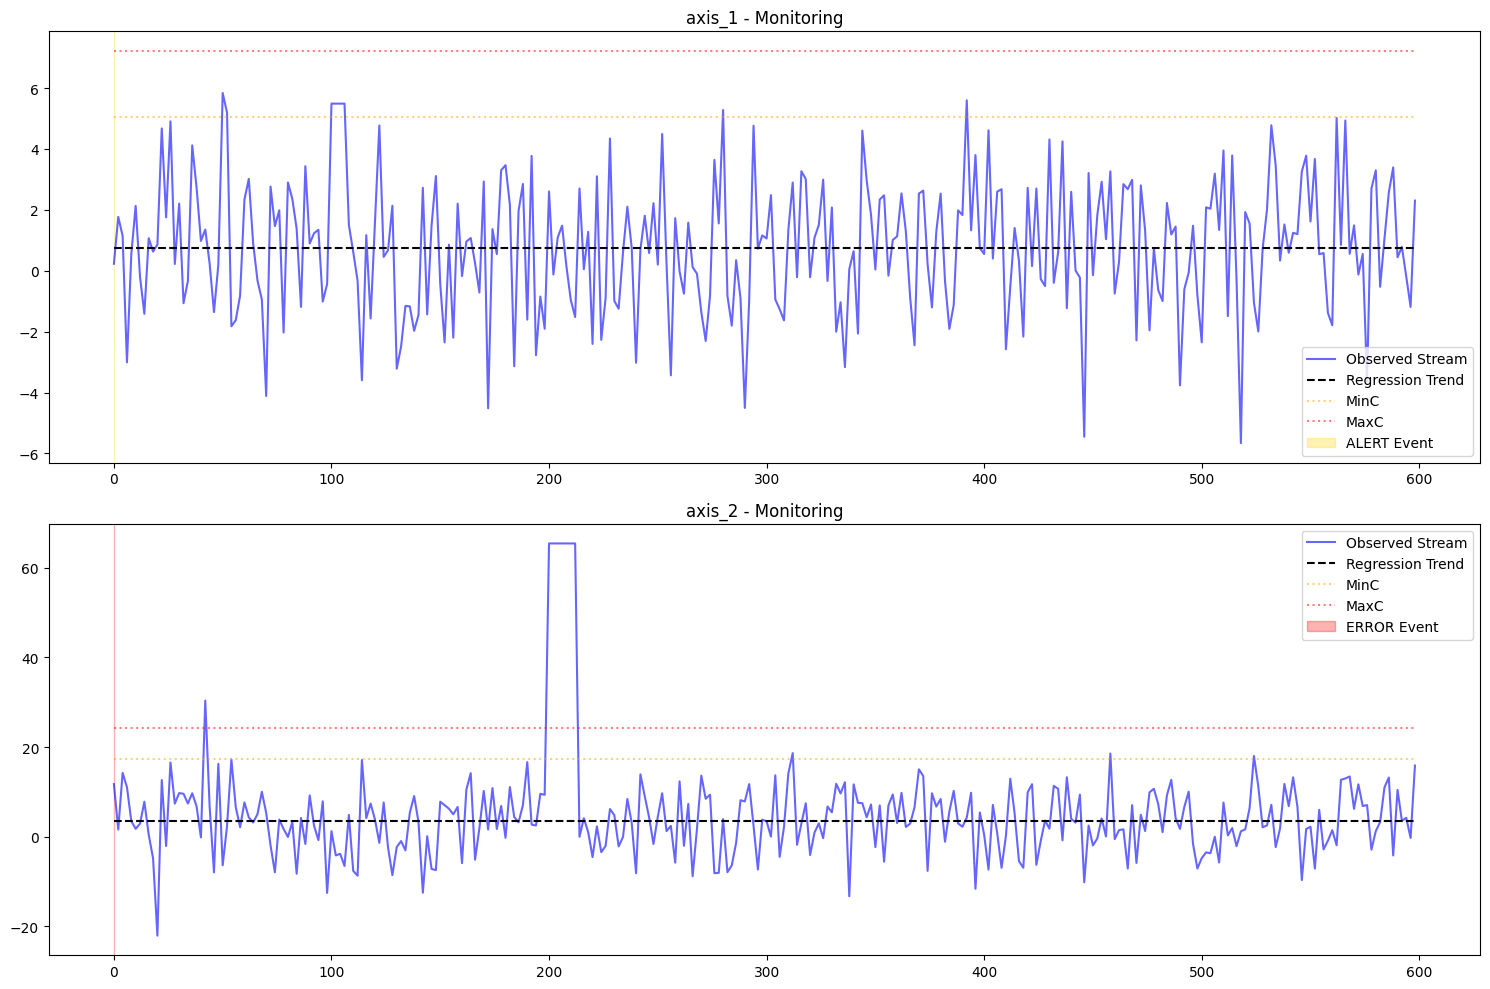

In [3]:
if alert_system.metadata:
    thresholds = alert_system.thresholds
    models = alert_system.models
    
    # Identify axes with anomalies
    anomalous_axes = set([e['axis'] for e in detected_events])
    # Also include the first couple axes if none detected (for demo)
    display_axes = list(anomalous_axes)
    if not display_axes:
        display_axes = ['axis_1', 'axis_2']
    
    fig, axs = plt.subplots(len(display_axes), 1, figsize=(15, 5 * len(display_axes)))
    if len(display_axes) == 1:
        axs = [axs]
        
    for i, axis in enumerate(display_axes):
        ax = axs[i]
        
        # Data
        X = df['seconds_from_start']
        y = df[axis]
        
        # Regression Line
        slope = models[axis]['slope']
        intercept = models[axis]['intercept']
        y_pred = slope * X + intercept
        
        # Threshold Lines
        min_c = thresholds[axis]['min_c']
        max_c = thresholds[axis]['max_c']
        
        ax.plot(X, y, label='Observed Stream', alpha=0.6, color='blue')
        ax.plot(X, y_pred, label='Regression Trend', color='black', linestyle='--')
        ax.plot(X, y_pred + min_c, color='orange', linestyle=':', alpha=0.5, label='MinC')
        ax.plot(X, y_pred + max_c, color='red', linestyle=':', alpha=0.5, label='MaxC')
        
        # Plot Detected Events
        axis_events = [e for e in detected_events if e['axis'] == axis]
        for event in axis_events:
            color = 'red' if event['type'] == 'ERROR' else 'gold'
            # Highlight the duration
            # Need to find x-values for start/end time. Approximate using index or seconds.
            # Start time is in event['start'] (datetime).
            # Df time is strings? No, synthetic gen probably returns strings? 
            # Check gen script: df['time'] is datetime objects.
            # But loaded from CSV, they become strings. Need to convert.
            # We'll skip precise x-span shading for simplicity and just mark the end point or range if possible.
            # Let's just create a span.
            start_ts = pd.to_datetime(event['start'])
            end_ts = pd.to_datetime(event['end'])
            
            # Find approx seconds for shading
            # This is tricky without converting 'time' col back to dt.
            # Visual approximation: just add a text annotation at the end.
            ax.axvspan(df['seconds_from_start'].min(), df['seconds_from_start'].min(), color=color, alpha=0.3, label=f"{event['type']} Event") # Dummy for legend
            
        ax.set_title(f'{axis} - Monitoring')
        ax.legend()
        
    plt.tight_layout()
    plt.show()